# Sperm_Tracker_V2

> This script tracks the movement of sperm cells in microscopy videos. It may be used for phase contrast microscopy videos of cells, but seems to perform better when using fluorescence videos of Hoescht 33342 stained nuclei since the tracked objects are more uniform in size and are less likely to cross paths. This version was created with help from GPT4 on 21Jun23.
> This script contains the following updates: 
> * plot the sperm_tracks on the resulting video(s) 
> * Plot the MSDs as a histogram inline using matplotlib
> * Calculate Euclidean distance and average curvilinear velocity for each sperm cell. 

In [ ]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from scipy.spatial.distance import pdist, squareform


class SpermTracker:
    def __init__(self, pixel_size, frame_rate, pixel_saturation, curvilinear_velocity_cutoff):
        self.sperm_positions = np.empty((0, 2), int)
        self.sperm_bboxes = []
        self.sperm_tracks = []
        self.pixel_size = pixel_size  # in microns
        self.frame_rate = frame_rate  # in frames per second
        self.pixel_saturation = pixel_saturation
        self.curvilinear_velocity_cutoff = curvilinear_velocity_cutoff
        self.contrast = contrast
        
    def adjust_brightness_contrast(self, img):
        # contrast is now taken from self.contrast instead of being fixed at 1.0
        brightness = int(self.pixel_saturation * 255)
        return cv2.convertScaleAbs(img, alpha=self.contrast, beta=brightness)

    def detect_sperm(self, frame):
        frame = self.adjust_brightness_contrast(frame)
        
        # Uncomment the following lines to alter the thresholding strategy
        #blurred = cv2.GaussianBlur(frame, (5, 5), 0)
        #_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        #_, thresh = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        _, thresh = cv2.threshold(frame, 60, 255, cv2.THRESH_BINARY)
        
        label_img = label(thresh)
        props = regionprops(label_img)

        detected_sperm = []
        sperm_bbox = []

        for prop in props:
            if 1 < prop.area < 200:
                detected_sperm.append(prop.centroid)
                sperm_bbox.append(prop.bbox)

        return np.array(detected_sperm), np.array(sperm_bbox), thresh

    def track_sperm(self, detected_sperm, sperm_bbox, frame, thresh, out, out_thresh, out_bc):
    
        # Write the brightness/contrast enhanced frames out to an .avi file for review
        adjusted_frame = self.adjust_brightness_contrast(frame)
        adjusted_frame_gray = cv2.cvtColor(adjusted_frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        out_bc.write(cv2.cvtColor(adjusted_frame_gray, cv2.COLOR_GRAY2BGR))
        
        for i, d in enumerate(detected_sperm):
            if self.sperm_positions.size > 0:
                distances = np.linalg.norm(self.sperm_positions - d, axis=1)
                if np.min(distances) < 20:
                    index = np.argmin(distances)
                    self.sperm_positions[index] = d
                    self.sperm_bboxes[index] = sperm_bbox[i]
                else:
                    self.sperm_positions = np.vstack([self.sperm_positions, d])
                    self.sperm_bboxes.append(sperm_bbox[i])
                    self.sperm_tracks.append([d])
            else:
                self.sperm_positions = np.vstack([self.sperm_positions, d])
                self.sperm_bboxes.append(sperm_bbox[i])
                self.sperm_tracks.append([d])

        # Draw bounding boxes only on each frame
        for i, pos in enumerate(self.sperm_positions):
            bbox = self.sperm_bboxes[i]
            cv2.rectangle(frame, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (0, 255, 0), 2)

            # Plotting tracks as points
            if len(self.sperm_tracks[i]) > 1:
                for point in self.sperm_tracks[i]:
                    p = (int(point[1]), int(point[0]))
                    cv2.circle(frame, p, 2, (0, 0, 255), -1)

        # Write the original frame with bounding boxes
        out.write(frame)
        
        # Write the thresholded frame without bounding boxes
        out_thresh.write(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))

        # Append the current positions to the tracks
        for i, pos in enumerate(self.sperm_positions):
            self.sperm_tracks[i].append(pos)


    def calculate_mean_square_displacement(self):
        msd_dict = {}
        avg_curvilinear_velocity_dict = {}

        motile_cells = 0
        non_motile_cells = 0

        for i, track in enumerate(self.sperm_tracks):
            track_array = np.array(track) * self.pixel_size
            sq_displacement = squareform(pdist(track_array))**2
            msd = np.mean(sq_displacement) / (1 / self.frame_rate)
            msd_dict[f'Sperm {i+1}'] = msd

            # Calculate average curvilinear velocity
            if len(track) > 1:
                sum_of_distances = np.sum(np.linalg.norm(track_array[1:] - track_array[:-1], axis=1))
                avg_curvilinear_velocity = sum_of_distances / ((len(track)-1) / self.frame_rate)
                avg_curvilinear_velocity_dict[f'Sperm {i+1}'] = avg_curvilinear_velocity
                
                # Count motile and non-motile cells
                if avg_curvilinear_velocity < self.curvilinear_velocity_cutoff:
                    non_motile_cells += 1
                else:
                    motile_cells += 1

        print(f'Motile Cells: {motile_cells}')
        print(f'Non-motile Cells: {non_motile_cells}')

        # Save data to a CSV file
        df = pd.DataFrame.from_dict(msd_dict, orient='index', columns=['MSD'])
        df['Avg Curvilinear Velocity'] = pd.DataFrame.from_dict(avg_curvilinear_velocity_dict, orient='index')
        df.to_csv('msd_data.csv')

        return msd_dict, avg_curvilinear_velocity_dict

    def process_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        out = cv2.VideoWriter('tracked_output.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (frame_width, frame_height))
        out_thresh = cv2.VideoWriter('thresh_output.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (frame_width, frame_height))
        out_bc = cv2.VideoWriter('bc_output.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (frame_width, frame_height))

        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                detected_sperm, sperm_bbox, thresh = self.detect_sperm(frame_gray)
                self.track_sperm(detected_sperm, sperm_bbox, frame, thresh, out, out_thresh, out_bc)
            else:
                break

        cap.release()
        out.release()
        out_thresh.release()
        cv2.destroyAllWindows()

        return self.calculate_mean_square_displacement()

# User-defined variables
pixel_size = 0.93  # in microns, user should adjust this valuea
frame_rate = 9.0  # in frames per second, user should adjust this value
pixel_saturation = 0.2  # between 0 and 1, user should adjust this value
contrast = 10.0  # user-defined contrast value
curvilinear_velocity_cutoff = 10.0  # user-defined cutoff value for curvilinear velocity in microns/second

# Process the video and get the mean square displacement of each sperm
tracker = SpermTracker(pixel_size, frame_rate, pixel_saturation, curvilinear_velocity_cutoff)
msd = tracker.process_video('A1_R3_Hoechst.avi')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data
msd_df = pd.read_csv('msd_data.csv')

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot a histogram of the Mean Square Displacements
axs[0].hist(msd_df['MSD'], bins=20, edgecolor='black')  # You can change the number of bins
axs[0].set_xlabel('Mean Square Displacement (microns^2/s)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Mean Square Displacements')

# Plot a histogram of the Average Curvilinear Velocity
axs[1].hist(msd_df['Avg Curvilinear Velocity'], bins=20, edgecolor='black')  # You can change the number of bins
axs[1].set_xlabel('Average Curvilinear Velocity (microns/s)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Average Curvilinear Velocity')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



## Explanation of the SpermTracker class concept

In Python, a **class** is a blueprint for creating objects. Objects have member variables and have behavior associated with them. 

In this script, the `SpermTracker` class is designed to process a video of sperm motion and compute various tracking statistics.

- `__init__`: This special function gets called whenever a new object of that class is instantiated. It defines several member variables that will store the state of each tracked sperm and the tracks they make.

- `detect_sperm`: A member function which takes a frame from the video, processes it to detect sperm and returns their locations and the processed frame.

- `track_sperm`: A member function which takes the detected sperm and their locations, and tracks their movement from frame to frame. It also visualizes this tracking on the frame.

- `calculate_mean_square_displacement`: A member function which calculates the Mean Square Displacement (MSD) of each sperm based on their tracks.

- `process_video`: A member function which reads the input video file, applies the sperm detection and tracking on each frame, writes the result to an output video file, and finally calculates the MSD of each sperm.

Creating an object of the class SpermTracker looks like this: `tracker = SpermTracker()`. This object is an instance of the `SpermTracker` class, and it has access to the member variables and functions defined in the class.

Finally, to process the video and compute the MSD of each sperm, we call the `process_video` function of the tracker object: `msd = tracker.process_video('E5_R1_Hoechst.avi')`.

In Python, classes are used to encapsulate data and the functions that operate on them. They provide a way of bundling data and functionality together, creating a new type where you can create your own methods and attributes as per your requirements. The `SpermTracker` class in this script is a good example of this, as it bundles together the data about each sperm and the processing of the video frames.


## Change the color of the bounding boxes

You can change the color of the bounding boxes by altering the color parameter in the `cv2.rectangle()` function. In OpenCV, the color is specified as a tuple in the BGR format (Blue, Green, Red), where each value ranges from 0 to 255.

In your script, the color of the bounding boxes is currently set to `(255, 0, 0)`, which represents blue in BGR format. You can change it to a different color by modifying the tuple. For instance:

- For blue color, use `(255, 0, 0)`
- For green color, use `(0, 255, 0)`
- For red color, use `(0, 0, 255)`
- For yellow color, use `(0, 255, 255)` (green + red)
- For magenta color, use `(255, 0, 255)` (blue + red)
- etc.

Here is the modified part of your script to change the bounding boxes color to green:

```python
    for i, pos in enumerate(self.sperm_positions):
        bbox = self.sperm_bboxes[i]  # Get the corresponding bounding box
        # Change color here, for example to green
        cv2.rectangle(frame, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (0, 255, 0), 2)
        cv2.rectangle(thresh, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (0, 255, 0), 2)


## Comparison between Mean Square Displacement and Euclidean Distance from Starting Location

The Mean Square Displacement (MSD) and the Euclidean distance from the starting location are related concepts, but they are not equivalent.

### Euclidean Distance from Starting Location
This is a direct measure of how far the sperm has traveled from its starting point. It is the straight-line distance between the starting and the ending position. Mathematically, for a sperm moving from position $(x_1, y_1)$ to position $(x_2, y_2)$, the Euclidean distance is:
   
$$\text{Distance} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$

### Mean Square Displacement (MSD)
MSD is a measure of the average square distance the sperm moves from its original position as a function of time. It accounts for both the path taken and how the position varies over time. MSD can be calculated as:
   
$$\text{MSD}(\tau) = \text{average}[(x(t + \tau) - x(t))^2 + (y(t + \tau) - y(t))^2] \text{ for all } t$$
   
where $\tau$ is the time lag, and the average is taken over all time points $t$.

In simpler terms, the Euclidean distance only considers the starting and ending positions, whereas the MSD considers all the positions of the sperm over time and the average of the squared differences from its initial position.

If the sperm were to move in a straight line without changing direction, the MSD would be equivalent to the square of the Euclidean distance. However, for more complex paths, the MSD will generally be different from the square of the Euclidean distance.


## Notes 26Jun23
> Added a 'hungarian algorithm' to solve the re-ID problem occuring in earlier implementations. Seems to track in a very robust manner. 

In [12]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment

class SpermTracker:
    def __init__(self, pixel_size, frame_rate, pixel_saturation, curvilinear_velocity_cutoff):
        self.sperm_positions = np.empty((0, 2), int)
        self.sperm_bboxes = []
        self.sperm_tracks = []
        self.pixel_size = pixel_size  # in microns
        self.frame_rate = frame_rate  # in frames per second
        self.pixel_saturation = pixel_saturation
        self.curvilinear_velocity_cutoff = curvilinear_velocity_cutoff

    def adjust_brightness_contrast(self, img):
        brightness = int(self.pixel_saturation * 255)
        contrast = 10.0  # Fixed contrast value
        return cv2.convertScaleAbs(img, alpha=contrast, beta=brightness)

    def detect_sperm(self, frame):
        frame = self.adjust_brightness_contrast(frame)

        _, thresh = cv2.threshold(frame, 60, 255, cv2.THRESH_BINARY) # Fixed threshold range

        label_img = label(thresh)
        props = regionprops(label_img)

        detected_sperm = []
        sperm_bbox = []

        for prop in props:
            if 1 < prop.area < 200:
                detected_sperm.append(prop.centroid)
                sperm_bbox.append(prop.bbox)

        return np.array(detected_sperm), np.array(sperm_bbox), thresh

    def track_sperm(self, detected_sperm, sperm_bbox, frame, thresh, out, out_thresh, out_bc):
        adjusted_frame = self.adjust_brightness_contrast(frame)
        adjusted_frame_gray = cv2.cvtColor(adjusted_frame, cv2.COLOR_BGR2GRAY)
        out_bc.write(cv2.cvtColor(adjusted_frame_gray, cv2.COLOR_GRAY2BGR))

        if self.sperm_positions.size > 0:
            cost_matrix = np.linalg.norm(self.sperm_positions[:, np.newaxis] - detected_sperm, axis=2)
            rows, cols = linear_sum_assignment(cost_matrix)

            new_sperm_positions = []
            new_sperm_bboxes = []
            new_sperm_tracks = []
            for r, c in zip(rows, cols):
                if cost_matrix[r, c] < 10:
                    self.sperm_tracks[r].append(detected_sperm[c])
                    new_sperm_positions.append(detected_sperm[c])
                    new_sperm_bboxes.append(sperm_bbox[c])
                else:
                    new_sperm_positions.append(detected_sperm[c])
                    new_sperm_bboxes.append(sperm_bbox[c])
                    new_sperm_tracks.append([detected_sperm[c]])

            self.sperm_positions = np.array(new_sperm_positions)
            self.sperm_bboxes = new_sperm_bboxes
            self.sperm_tracks.extend(new_sperm_tracks)
        else:
            self.sperm_positions = detected_sperm
            self.sperm_bboxes = sperm_bbox.tolist()
            self.sperm_tracks = [[d] for d in detected_sperm]

        for i, pos in enumerate(self.sperm_positions):
            bbox = self.sperm_bboxes[i]
            cv2.rectangle(frame, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (0, 255, 0), 2)
            
            # Plotting tracks as points
            if len(self.sperm_tracks[i]) > 1:
                for point in self.sperm_tracks[i]:
                    p = (int(point[1]), int(point[0]))
                    cv2.circle(frame, p, 2, (0, 0, 255), -1)

        out.write(frame)
        out_thresh.write(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))

        # Append the current positions to the tracks
        for i, pos in enumerate(self.sperm_positions):
            self.sperm_tracks[i].append(pos)


    def calculate_mean_square_displacement(self):
        msd_dict = {}
        avg_curvilinear_velocity_dict = {}

        motile_cells = 0
        non_motile_cells = 0

        for i, track in enumerate(self.sperm_tracks):
            track_array = np.array(track) * self.pixel_size
            sq_displacement = squareform(pdist(track_array))**2
            msd = np.mean(sq_displacement) / (1 / self.frame_rate)
            msd_dict[f'Sperm {i+1}'] = msd

            # Calculate average curvilinear velocity
            if len(track) > 1:
                sum_of_distances = np.sum(np.linalg.norm(track_array[1:] - track_array[:-1], axis=1))
                avg_curvilinear_velocity = sum_of_distances / ((len(track)-1) / self.frame_rate)
                avg_curvilinear_velocity_dict[f'Sperm {i+1}'] = avg_curvilinear_velocity
                
                # Count motile and non-motile cells
                if avg_curvilinear_velocity < self.curvilinear_velocity_cutoff:
                    non_motile_cells += 1
                else:
                    motile_cells += 1

        print(f'Motile Cells: {motile_cells}')
        print(f'Non-motile Cells: {non_motile_cells}')

        # Save data to a CSV file
        df = pd.DataFrame.from_dict(msd_dict, orient='index', columns=['MSD'])
        df['Avg Curvilinear Velocity'] = pd.DataFrame.from_dict(avg_curvilinear_velocity_dict, orient='index')
        df.to_csv('msd_data.csv')

        return msd_dict, avg_curvilinear_velocity_dict

    def process_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        out = cv2.VideoWriter('tracked_output.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (frame_width, frame_height))
        out_thresh = cv2.VideoWriter('thresh_output.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (frame_width, frame_height))
        out_bc = cv2.VideoWriter('bc_output.avi', cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, (frame_width, frame_height))

        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                detected_sperm, sperm_bbox, thresh = self.detect_sperm(frame_gray)
                self.track_sperm(detected_sperm, sperm_bbox, frame, thresh, out, out_thresh, out_bc)
            else:
                break

        cap.release()
        out.release()
        out_thresh.release()
        cv2.destroyAllWindows()

        return self.calculate_mean_square_displacement()

# User-defined variables
pixel_size = 0.93  # in microns, user should adjust this valuea
frame_rate = 9.0  # in frames per second, user should adjust this value
pixel_saturation = 0.2  # between 0 and 1, user should adjust this value
curvilinear_velocity_cutoff = 20.0  # user-defined cutoff value for curvilinear velocity in microns/second

# Process the video and get the mean square displacement of each sperm
tracker = SpermTracker(pixel_size, frame_rate, pixel_saturation, curvilinear_velocity_cutoff)
msd = tracker.process_video('E5_R1_Hoechst.avi')

Motile Cells: 72
Non-motile Cells: 11


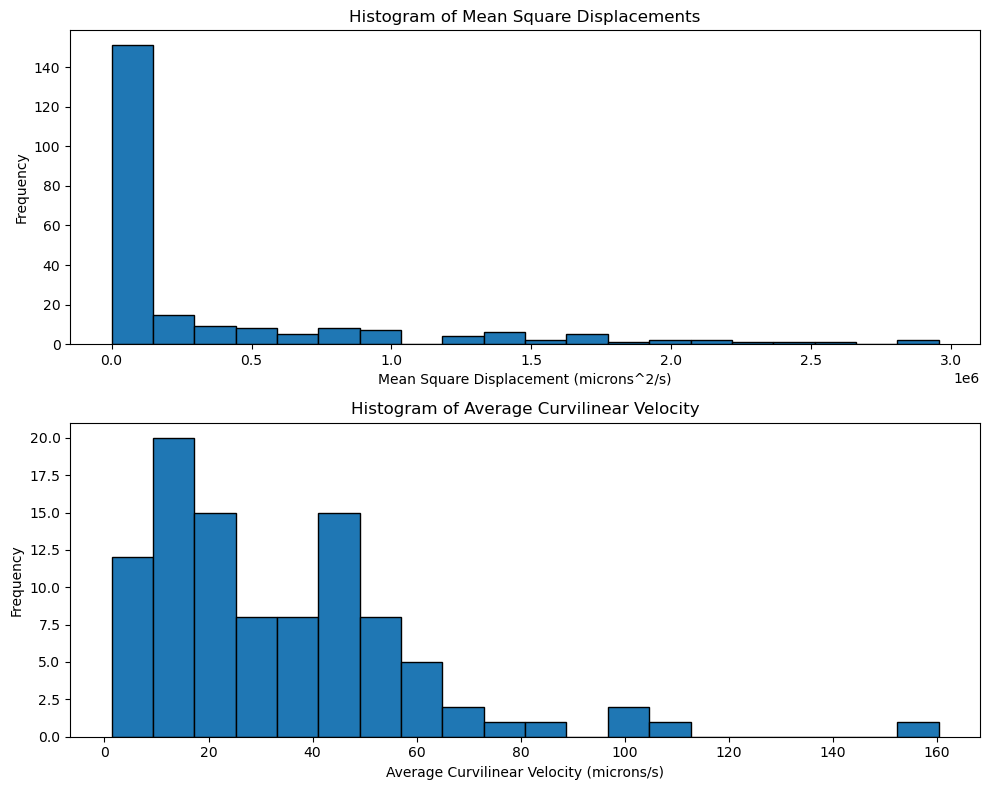

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the data
msd_df = pd.read_csv('msd_data.csv')

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot a histogram of the Mean Square Displacements
axs[0].hist(msd_df['MSD'], bins=20, edgecolor='black')  # You can change the number of bins
axs[0].set_xlabel('Mean Square Displacement (microns^2/s)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Mean Square Displacements')

# Plot a histogram of the Average Curvilinear Velocity
axs[1].hist(msd_df['Avg Curvilinear Velocity'], bins=20, edgecolor='black')  # You can change the number of bins
axs[1].set_xlabel('Average Curvilinear Velocity (microns/s)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Average Curvilinear Velocity')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Explanation of current track_sperm method

The `track_sperm` method is responsible for tracking the sperms in each frame and drawing bounding boxes around them.

### Parameters:

- `self`: the instance of the `SpermTracker` class.
- `detected_sperm`: a numpy array of the positions of the detected sperms in the current frame.
- `sperm_bbox`: a numpy array of the bounding boxes around the detected sperms in the current frame.
- `frame`: the current video frame.
- `thresh`: the thresholded frame.
- `out`: the VideoWriter object for writing the original video with bounding boxes.
- `out_thresh`: the VideoWriter object for writing the thresholded video.
- `out_bc`: the VideoWriter object for writing the brightness/contrast enhanced video.

### Step-by-step explanation:

1. Adjust the brightness and contrast of the frame using the `adjust_brightness_contrast` method and convert the adjusted frame to grayscale. Write the grayscale frame to the output file `out_bc`.

2. If there are previously tracked sperm positions, compute a cost matrix which represents the distances between previously tracked positions and newly detected positions in the current frame.

3. Use the Hungarian algorithm to solve the assignment problem, which involves finding the best assignment of detected sperms to tracks that minimizes the total distance. This is done using the `linear_sum_assignment` method.

4. Initialize empty lists `new_sperm_positions`, `new_sperm_bboxes`, and `new_sperm_tracks` to keep track of the updated positions, bounding boxes, and tracks of the sperms, respectively.

5. Iterate through the row and column indices from the Hungarian algorithm. For each pair of indices:
    - If the distance is less than 20 (a threshold value), append the detected position to the corresponding track and append the position and bounding box to the new positions and bounding boxes lists.
    - Otherwise, this is likely a new sperm, so append the position and bounding box to the new lists and create a new track for this sperm.

6. Assign the new lists back to the class attributes `self.sperm_positions`, `self.sperm_bboxes`, and `self.sperm_tracks`.

7. If there were no previously tracked positions, initialize the class attributes with the positions, bounding boxes, and tracks of the detected sperms.

8. Draw the bounding boxes around the sperms in the current frame and plot the tracks as points.

9. Write the frame with bounding boxes to the output file `out` and the thresholded frame to the output file `out_thresh`.

10. Append the current positions to the tracks.

### Note

This method uses the Hungarian algorithm to efficiently track multiple objects across frames, which is particularly useful in cases where the objects are moving, and their positions are changing rapidly.


## Explanation of calculate_mean_square_displacement method

The `calculate_mean_square_displacement` method is responsible for calculating the mean square displacement (MSD) and the average curvilinear velocity of the sperms that have been tracked. It also counts the number of motile and non-motile cells based on the average curvilinear velocity.

### Parameters:

- `self`: the instance of the `SpermTracker` class.

### Step-by-step explanation:

1. Initialize an empty dictionary `msd_dict` to store the mean square displacement of each sperm.

2. Initialize an empty dictionary `avg_curvilinear_velocity_dict` to store the average curvilinear velocity of each sperm.

3. Initialize two counters `motile_cells` and `non_motile_cells` to zero. These will keep track of the number of motile and non-motile cells, respectively.

4. Iterate through each tracked sperm by enumerating through `self.sperm_tracks`. For each track:
    a. Convert the track to a numpy array and multiply by `self.pixel_size` to convert the positions to physical units (e.g., micrometers).
    b. Calculate the square of the pairwise distances between all points in the track using the `pdist` function and square the result to obtain the square displacements. 
    c. Calculate the mean square displacement (MSD) by taking the mean of the square displacements and dividing by the inverse of the frame rate. Store the MSD in the `msd_dict` dictionary.
    d. Calculate the average curvilinear velocity by summing the distances between consecutive points in the track and dividing by the total time. Store the average curvilinear velocity in the `avg_curvilinear_velocity_dict` dictionary.
    e. If the average curvilinear velocity is below a certain threshold (`self.curvilinear_velocity_cutoff`), increment the `non_motile_cells` counter, otherwise increment the `motile_cells` counter.

5. Print the number of motile cells and non-motile cells to the console.

### Additional Information:

- Mean Square Displacement (MSD) is a measure used to quantify the spatial extent of the motion of particles (in this case, sperms). It is the average of the squares of the displacements of the particles and is a function of time.
- The average curvilinear velocity is the total path length traveled by a sperm divided by the time taken. It gives an idea of how fast the sperm is moving along its path.
- By comparing the average curvilinear velocity to a threshold, the sperms are classified as either motile or non-motile. Motile cells are those that show significant movement, while non-motile cells are relatively stationary or moving very slowly.
